In [2553]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer #fills missing values intelligently
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay, f1_score

## Loading in the Data

In [2554]:
data = pd.read_csv('./datasets/train.csv')


In [2555]:
test = pd.read_csv('./datasets/test.csv')

In [2556]:
data.isna().sum()[data.isna().sum() > 350].index

Index(['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature'], dtype='object')

In [2557]:
[data.drop(columns=i, inplace = True) for i in data.isna().sum()[data.isna().sum() > 350].index]

[None, None, None, None, None]

## Above I am removing any feature missing more than 350 columns

In [2558]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Lot Shape        2051 non-null   object 
 8   Land Contour     2051 non-null   object 
 9   Utilities        2051 non-null   object 
 10  Lot Config       2051 non-null   object 
 11  Land Slope       2051 non-null   object 
 12  Neighborhood     2051 non-null   object 
 13  Condition 1      2051 non-null   object 
 14  Condition 2      2051 non-null   object 
 15  Bldg Type        2051 non-null   object 
 16  House Style      2051 non-null   object 
 17  Overall Qual  

In [2559]:
data.select_dtypes(object).columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Sale Type'],
      dtype='object')

In [2560]:
test.select_dtypes(object).values

array([['RM', 'Pave', 'Grvl', ..., nan, nan, 'WD '],
       ['RL', 'Pave', nan, ..., nan, nan, 'WD '],
       ['RL', 'Pave', nan, ..., nan, nan, 'New'],
       ...,
       ['RL', 'Pave', nan, ..., nan, nan, 'WD '],
       ['RL', 'Pave', nan, ..., 'GdWo', nan, 'WD '],
       ['RL', 'Pave', nan, ..., 'GdWo', nan, 'WD ']], dtype=object)

## Below I am setting up an OHE to encode our data using a column selector to choose categorical features only. 
## Then passing it through a KNN imputer to fill in null values.

In [2561]:
#creating identical Test Data to predict
testdf = pd.DataFrame()
for i in data.drop(columns='SalePrice').columns:
    testdf[i]=test[i]

In [2562]:
encodable_cols = [i for i in data.select_dtypes(object).columns]

ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

smart_ohe = make_column_transformer(
  (ohe, encodable_cols),
  remainder = "passthrough",
  verbose_feature_names_out = False
)

imp = KNNImputer()

In [2563]:
ohedata = smart_ohe.fit_transform(data)
fulldata = imp.fit_transform(ohedata)
cols = smart_ohe.get_feature_names()
datadf = pd.DataFrame(fulldata, columns=cols)
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Columns: 282 entries, onehotencoder__x0_A (agr) to SalePrice
dtypes: float64(282)
memory usage: 4.4 MB


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [2564]:
testohedata = smart_ohe.fit_transform(testdf)
testfulldata = imp.fit_transform(testohedata)
cols = smart_ohe.get_feature_names()
testdatadf = pd.DataFrame(testfulldata, columns=cols)
testdatadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Columns: 267 entries, onehotencoder__x0_C (all) to Yr Sold
dtypes: float64(267)
memory usage: 1.8 MB


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [2565]:
datadf.corr()['SalePrice'][(datadf.corr()['SalePrice']>.40) | (datadf.corr()['SalePrice']<-.25)]

onehotencoder__x0_RM        -0.281951
onehotencoder__x2_Reg       -0.306291
onehotencoder__x7_NridgHt    0.448647
onehotencoder__x16_None     -0.424088
onehotencoder__x17_Ex        0.493861
onehotencoder__x17_Gd        0.446685
onehotencoder__x17_TA       -0.600362
onehotencoder__x19_CBlock   -0.355535
onehotencoder__x19_PConc     0.529047
onehotencoder__x20_Ex        0.586497
onehotencoder__x20_TA       -0.456979
onehotencoder__x22_No       -0.293106
onehotencoder__x23_GLQ       0.463549
onehotencoder__x26_Ex        0.453255
onehotencoder__x26_TA       -0.343542
onehotencoder__x27_N        -0.277378
onehotencoder__x29_Ex        0.551284
onehotencoder__x29_TA       -0.540860
onehotencoder__x31_Detchd   -0.370344
onehotencoder__x32_Fin       0.422936
onehotencoder__x32_Unf      -0.432220
onehotencoder__x35_N        -0.273613
PID                         -0.255052
Overall Qual                 0.800207
Year Built                   0.571849
Year Remod/Add               0.550370
Mas Vnr Area

## Below I am creating a DataFrame and fillling it with only the filtered features as columns.
## I used a mask to filter the DataFrame and return a list of only features that correlated greater than or less than what ever you input. 
## Also the length is printed below, becareful when running a grid search on a df with 40 or more columns.
## feel free to adjust the minimum and maximum to try different percentages. The length is printed below, becareful when running a grid search on a df with more than 35 columns. I found the best results around .35 and -.25. 
## As discovered during presentations the best model is a basic linear regression. The more complex models would be good to use if you had less data available.

In [2566]:
X = datadf.drop(columns='SalePrice')
y = datadf['SalePrice']
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

In [2567]:
lr = LinearRegression()
lr.fit(xtrain, ytrain)
lr.score(xtrain, ytrain), mean_squared_error(y, lr.predict(X), squared=False)

(0.9483595242907364, 23814.151334826314)

In [2539]:
corrdf = pd.DataFrame()
for i in datadf.corr()['SalePrice'][(datadf.corr()['SalePrice']>.35) | (datadf.corr()['SalePrice']<-.25)].index:
    corrdf[i]=datadf[i]
corrdf['SalePrice']=datadf['SalePrice']
corrdf.columns, len(corrdf.columns)

(Index(['onehotencoder__x0_RM', 'onehotencoder__x3_Reg',
        'onehotencoder__x8_NridgHt', 'onehotencoder__x17_None',
        'onehotencoder__x18_Ex', 'onehotencoder__x18_Gd',
        'onehotencoder__x18_TA', 'onehotencoder__x20_CBlock',
        'onehotencoder__x20_PConc', 'onehotencoder__x21_Ex',
        'onehotencoder__x21_TA', 'onehotencoder__x23_Gd',
        'onehotencoder__x23_No', 'onehotencoder__x24_GLQ',
        'onehotencoder__x27_Ex', 'onehotencoder__x27_TA',
        'onehotencoder__x28_N', 'onehotencoder__x30_Ex',
        'onehotencoder__x30_TA', 'onehotencoder__x32_Gd',
        'onehotencoder__x32_nan', 'onehotencoder__x33_Attchd',
        'onehotencoder__x33_Detchd', 'onehotencoder__x34_Fin',
        'onehotencoder__x34_Unf', 'onehotencoder__x37_N',
        'onehotencoder__x41_New', 'PID', 'Overall Qual', 'Year Built',
        'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF',
        '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces

In [2540]:
finalx = pd.DataFrame()
for i in corrdf.drop(columns='SalePrice').columns:
    finalx[i]=testdatadf[i]

In [2541]:
X = corrdf.drop(columns='SalePrice')
y = corrdf['SalePrice']

In [2542]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

In [2543]:
lr = LinearRegression()
lr.fit(xtrain, ytrain)
lr.score(xtrain, ytrain), mean_squared_error(y, lr.predict(X), squared=False)

(0.8486993898923055, 29976.852908344383)

In [2544]:
las = Lasso(alpha=100)
las.fit(xtrain, ytrain)
las.score(xtest, ytest), mean_squared_error(ytest, las.predict(xtest), squared=False)

(0.8830842776079725, 26650.71335168774)

In [2545]:
pipe = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
pipe.fit(xtrain, ytrain)
pipe.score(xtest, ytest), mean_squared_error(ytest, pipe.predict(xtest), squared=False)

(0.8824970665225392, 26717.556343813514)

In [2546]:
pipe1 = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    KNeighborsRegressor()
)
params = {'polynomialfeatures__interaction_only': [True, False], 'polynomialfeatures__degree': [2, 3], 'kneighborsregressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
gs1 = GridSearchCV(pipe1, params, n_jobs=-1)
gs1.fit(xtrain, ytrain)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'kneighborsregressor__algorithm': ['auto', 'ball_tree',
                                                            'kd_tree',
                                                            'brute'],
                         'polynomialfeatures__degree': [2, 3],
                         'polynomialfeatures__interaction_only': [True, False]})

In [2547]:
gs1.score(xtest, ytest), mean_squared_error(ytest, gs1.predict(xtest), squared=False), gs1.best_params_

(0.8477769816121483,
 30409.728590684008,
 {'kneighborsregressor__algorithm': 'auto',
  'polynomialfeatures__degree': 2,
  'polynomialfeatures__interaction_only': False})

In [2548]:
pipe2 = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Lasso()
)
params = {'polynomialfeatures__interaction_only': [True, False], 'polynomialfeatures__degree': [2, 3], 'lasso__alpha':[450, 550, 650]}
gs2 = GridSearchCV(pipe2, params, n_jobs=-1)
gs2.fit(xtrain, ytrain);

In [2549]:
gs2.score(xtest, ytest), mean_squared_error(ytest, gs2.predict(xtest), squared=False), gs2.best_params_

(0.9066020934349138,
 23819.95575458616,
 {'lasso__alpha': 650,
  'polynomialfeatures__degree': 2,
  'polynomialfeatures__interaction_only': True})

In [2550]:
pipe3 = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge()
)
params = {'polynomialfeatures__interaction_only': [True, False], 'polynomialfeatures__degree': [2, 3], 'ridge__alpha':[250, 356, 450]}
gs3 = GridSearchCV(pipe3, params, n_jobs=-1)
gs3.fit(xtrain, ytrain);

In [2551]:
gs3.score(xtest, ytest), mean_squared_error(ytest, gs3.predict(xtest), squared=False), gs3.best_params_

(0.8957718973741281,
 25163.137770102487,
 {'polynomialfeatures__degree': 2,
  'polynomialfeatures__interaction_only': True,
  'ridge__alpha': 450})

In [2417]:
finalpreds = gs2.predict(finalx)
finalpreds.shape, test['Id'].shape
prediction = pd.DataFrame()
prediction['Id']=test['Id']
prediction['SalePrice']=finalpreds
prediction.set_index('Id', inplace=True) 
prediction.head()  

,SalePrice
Id,
2658,145931.166269
2718,164623.963162
2414,190579.791849
1989,117713.107215
625,177305.115243


In [2256]:
prediction.to_csv('nickprediction.csv') 

In [1544]:
['Lot Frontage', 'Lot Area', 'Overall Qual', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'SalePrice']

['Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Half Bath',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'SalePrice']

In [2033]:
datadf.corr()['SalePrice'][datadf.corr()['SalePrice']<-.26]

onehotencoder__x0_RM        -0.281951
onehotencoder__x3_Reg       -0.306291
onehotencoder__x17_None     -0.424088
onehotencoder__x18_TA       -0.600362
onehotencoder__x20_CBlock   -0.355535
onehotencoder__x21_TA       -0.456979
onehotencoder__x23_No       -0.293106
onehotencoder__x27_TA       -0.343542
onehotencoder__x28_N        -0.277378
onehotencoder__x30_TA       -0.540860
onehotencoder__x32_nan      -0.485858
onehotencoder__x33_Detchd   -0.370344
onehotencoder__x34_Unf      -0.432220
onehotencoder__x37_N        -0.273613
Name: SalePrice, dtype: float64

In [2153]:
datadf.corr()['SalePrice'][datadf.corr()['SalePrice']>.45]

onehotencoder__x18_Ex       0.493861
onehotencoder__x20_PConc    0.529047
onehotencoder__x21_Ex       0.586497
onehotencoder__x24_GLQ      0.463549
onehotencoder__x27_Ex       0.453255
onehotencoder__x30_Ex       0.551284
Overall Qual                0.800207
Year Built                  0.571849
Year Remod/Add              0.550370
Mas Vnr Area                0.513605
Total Bsmt SF               0.628989
1st Flr SF                  0.618486
Gr Liv Area                 0.697038
Full Bath                   0.537969
TotRms AbvGrd               0.504014
Fireplaces                  0.471093
Garage Yr Blt               0.547882
Garage Cars                 0.648225
Garage Area                 0.650302
SalePrice                   1.000000
Name: SalePrice, dtype: float64

## I used the attributes with the strongest correlation and logical inference to help select the best ways to add value in the market

Text(0.5, 0, 'Location Based Area')

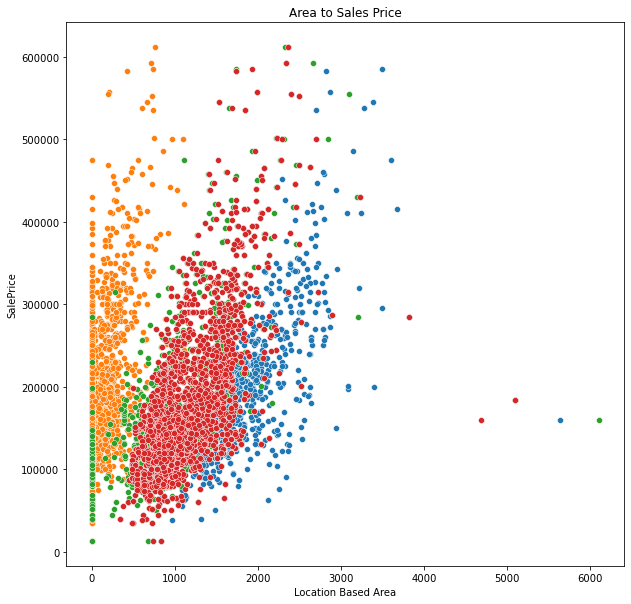

In [2154]:
Fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=datadf['Gr Liv Area'], y=datadf['SalePrice'],)
sns.scatterplot(x=datadf['Mas Vnr Area'], y=datadf['SalePrice'],)
sns.scatterplot(x=datadf['Total Bsmt SF'], y=datadf['SalePrice'])
sns.scatterplot(x=datadf['1st Flr SF'], y=datadf['SalePrice'])
plt.title('Area to Sales Price')
plt.xlabel('Location Based Area')

Text(0.5, 1.0, 'Overall Quality to Sales Price')

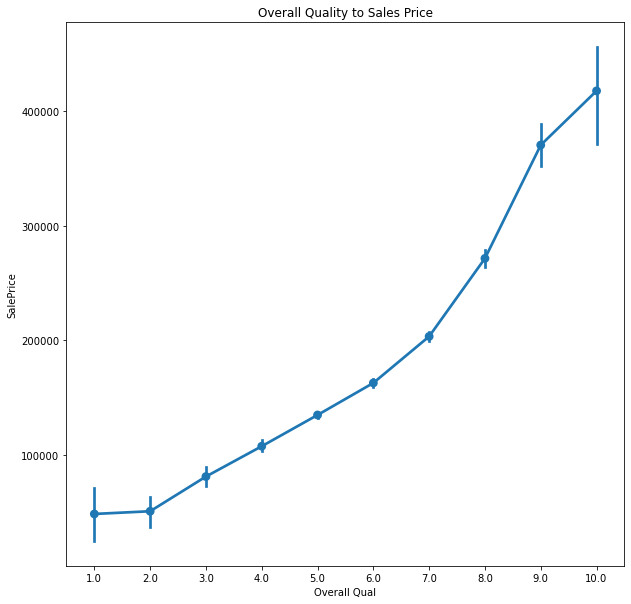

In [2146]:
Fig, ax = plt.subplots(figsize=(10, 10))
sns.pointplot(x=datadf['Overall Qual'], y=datadf['SalePrice'])
plt.title('Overall Quality to Sales Price')
p


Text(0.5, 1.0, 'Year Remodelled to Sales Price')

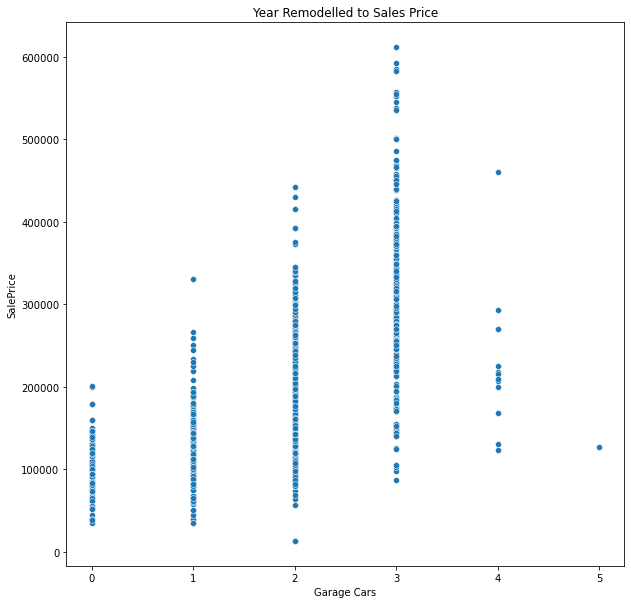

In [2155]:
Fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=datadf['Garage Cars'], y=datadf['SalePrice'])
plt.title('Year Remodelled to Sales Price')